In [25]:
import os
#os.chdir("./PycharmProjects/one-shot-face-recognition")
import torch
import torch.nn as nn
import torch
import time
import torchvision.transforms as transforms
import torch.optim as optim
import torchvision.transforms.functional as FT
from tqdm import tqdm
from torch.utils.data import DataLoader
from utils import (
    non_max_suppression,
    mean_average_precision,
    intersection_over_union,
    cellboxes_to_boxes,
    get_bboxes,
    plot_image,
    save_checkpoint,
    load_checkpoint,
    get_face,
    face_verification
)
from loss import YoloLoss
from model import Yolov1, SiameseNetwork
from dataset import Compose
from PIL import Image
import torchvision
import numpy as np
from torchvision import datasets, models
import matplotlib.pyplot as plt
from torchvision.utils import draw_bounding_boxes

In [5]:
# yolo_model = Yolov1(split_size=7, num_boxes=2, num_classes=2)
# siamese_model = SiameseNetwork()
# yolo_optimizer = optim.Adam(
#         yolo_model.parameters(), lr=1e-5
# )
# siamese_optimizer = optim.Adam(
#     siamese_model.parameters(), lr=1e-4
# )

In [12]:
fasterRCNN_model = models.detection.fasterrcnn_mobilenet_v3_large_fpn(pretrained=True)
in_features = fasterRCNN_model.roi_heads.box_predictor.cls_score.in_features  # we need to change the head
n_classes = 3
fasterRCNN_model.roi_heads.box_predictor = models.detection.faster_rcnn.FastRCNNPredictor(
    in_features, n_classes)
siamese_model = SiameseNetwork()
params = [p for p in fasterRCNN_model.parameters() if p.requires_grad]
fasterRCNN_optimizer = torch.optim.SGD(params, lr=0.001, momentum=0.9, nesterov=True, weight_decay=1e-4)
siamese_optimizer = optim.Adam(siamese_model.parameters(), lr=1e-4)

In [13]:
# checkpoint = torch.load("load_models/YOLOv1.pth.tar", map_location=torch.device("cpu"))
# start_epoch = load_checkpoint(checkpoint, yolo_model, yolo_optimizer)
# checkpoint = torch.load("load_models/siamese.pth.tar", map_location=torch.device("cpu"))
# start_epoch = load_checkpoint(checkpoint, siamese_model, siamese_optimizer)

In [15]:
checkpoint = torch.load("load_models/fasterRCNN.pth.tar", map_location=torch.device("cpu"))
fasterRCNN_model.load_state_dict(checkpoint["state_dict"])
fasterRCNN_optimizer.load_state_dict(checkpoint["optimizer"])
checkpoint = torch.load("load_models/siamese.pth.tar", map_location=torch.device("cpu"))
start_epoch = load_checkpoint(checkpoint, siamese_model, siamese_optimizer)

=> Loading checkpoint


In [4]:
# group_photo = "graphs_and_charts/example.png"
# image = Image.open(group_photo).convert("RGB")
# transform = Compose([transforms.Resize((448, 448)), transforms.ToTensor()])
# image, _ = transform(image, [])
# please = torch.unsqueeze(image,0)
# out = yolo_model(please)

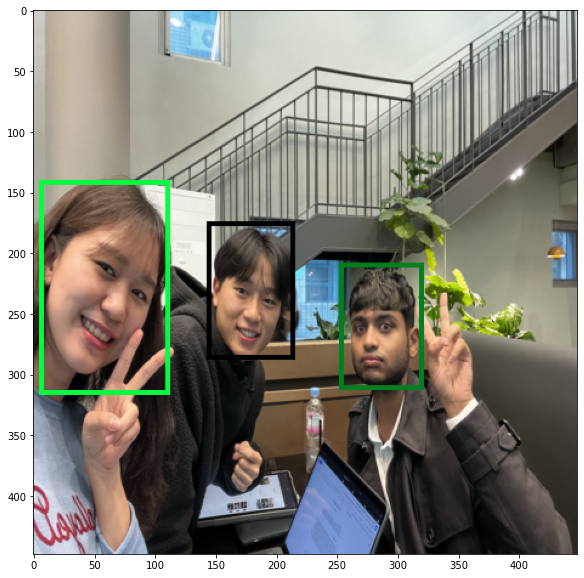

In [33]:
fasterRCNN_model.eval()
group_photo = "graphs_and_charts/example.png"
image = Image.open(group_photo).convert("RGB")
transform = Compose([transforms.Resize((448, 448)), transforms.ToTensor()])
image, _ = transform(image, [])
img_int = image.clone().detach()*255
img_int = img_int.to(torch.uint8)
with torch.no_grad():
    prediction = fasterRCNN_model([image])
    pred = prediction[0]
fig = plt.figure(figsize=(14, 10))
plt.imshow(draw_bounding_boxes(img_int,
    pred['boxes'][pred['scores'] > 0.7], width=4
).permute(1, 2, 0))

In [34]:
# bboxes = cellboxes_to_boxes(out)
# bboxes = non_max_suppression(bboxes[0], iou_threshold=0.5,
#                              threshold=0.95, box_format="midpoint")
# plot_image(image.permute(1, 2, 0).to("cpu"), bboxes)

In [37]:
pred

{'boxes': tensor([[143.9082, 174.9459, 215.7236, 287.9940],
         [252.9628, 208.0793, 321.2158, 312.4271],
         [  5.9823, 140.7966, 112.2282, 316.7636],
         [250.9648, 208.3394, 323.9518, 313.3849],
         [  7.1976, 143.6768, 115.0915, 324.3807],
         [144.7868, 174.0730, 219.5633, 290.5716],
         [220.7028, 315.0413, 243.2812, 361.3122]]),
 'labels': tensor([2, 2, 2, 1, 1, 1, 1]),
 'scores': tensor([0.9977, 0.9748, 0.9468, 0.4073, 0.3619, 0.2684, 0.1659])}

In [ ]:
get_face(img_int.permute(1,2,0), pred["boxes"][pred["scores"] > 0.7], )

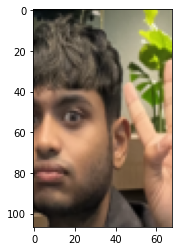

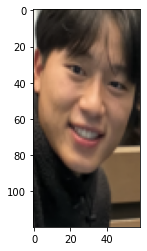

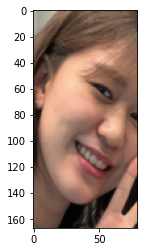

In [6]:
folder = "support_set"
get_face(image.permute(1,2,0), bboxes, folder)

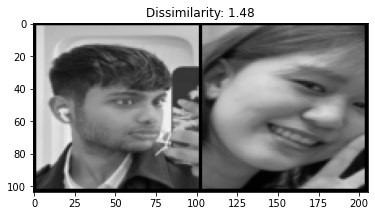

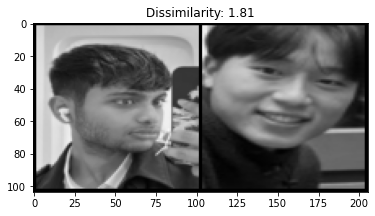

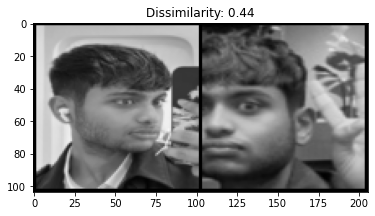

In [7]:
query_image = "query_image/query1.jpg"
support_set = "support_set"
transform = transforms.Compose([transforms.Resize((100,100)),transforms.ToTensor()])
lowest_score, lowest_idx = face_verification(query_image, support_set, transform, siamese_model)

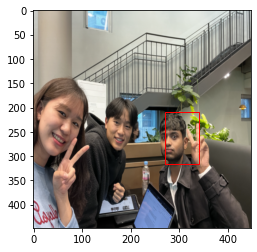

In [8]:
final = np.expand_dims(bboxes[lowest_idx], 0)
plot_image(image.permute(1, 2, 0).to("cpu"), final)